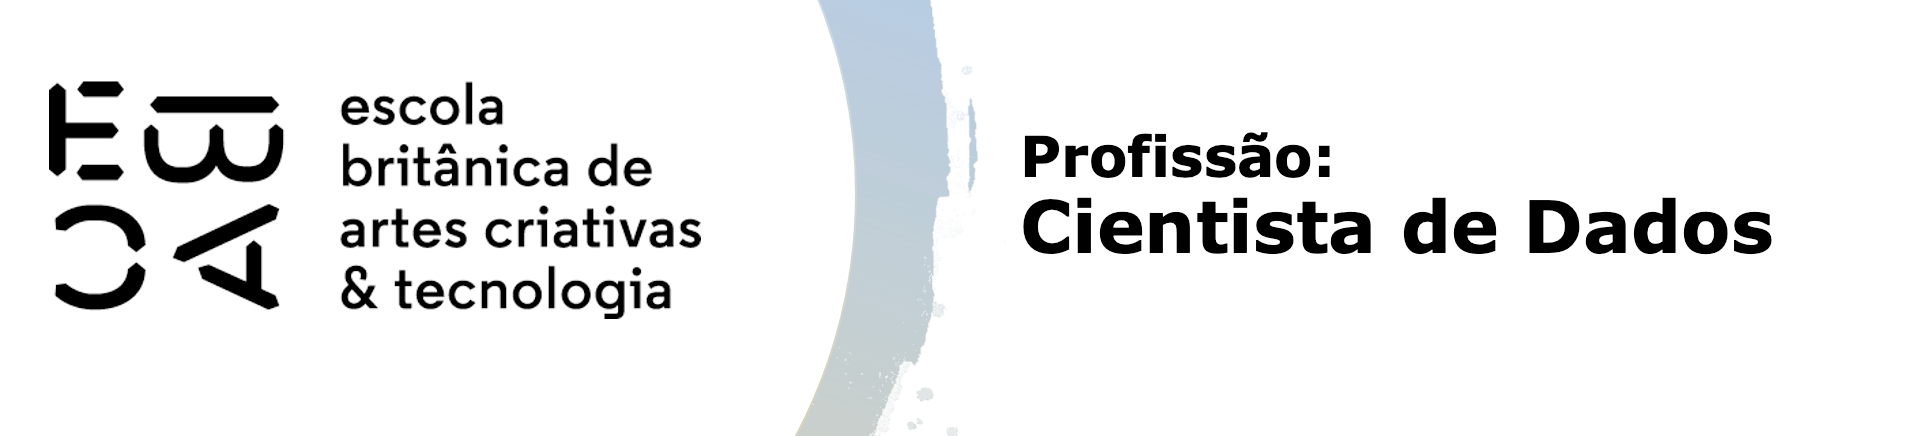

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import scipy.cluster.hierarchy as shc

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix

from scipy.spatial.distance import pdist, squareform

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

In [3]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [6]:
variaveis = [ 'Administrative', 'Administrative_Duration', 'Informational',
    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'SpecialDay',
    'Month', 'Weekend']

df1 = df[variaveis]
for coluna in df1.columns:
    print(f"Coluna: {coluna}")
    print("Valores únicos:")
    print(df[coluna].unique())
    print("Contagem de valores:")
    print(df[coluna].value_counts())
    print('\n')

Coluna: Administrative
Valores únicos:
[ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26]
Contagem de valores:
Administrative
0     5768
1     1354
2     1114
3      915
4      765
5      575
6      432
7      338
8      287
9      225
10     153
11     105
12      86
13      56
14      44
15      38
16      24
17      16
18      12
19       6
24       4
22       4
23       3
21       2
20       2
27       1
26       1
Name: count, dtype: int64


Coluna: Administrative_Duration
Valores únicos:
[  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]
Contagem de valores:
Administrative_Duration
0.000000      5903
4.000000        56
5.000000        53
7.000000        45
11.000000       42
              ... 
68.014286        1
362.300000       1
90.700000        1
760.900000       1
150.357143       1
Name: count, Length: 3335, dtype: int64


Coluna: Informational
Valores únicos:
[ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]
Contag

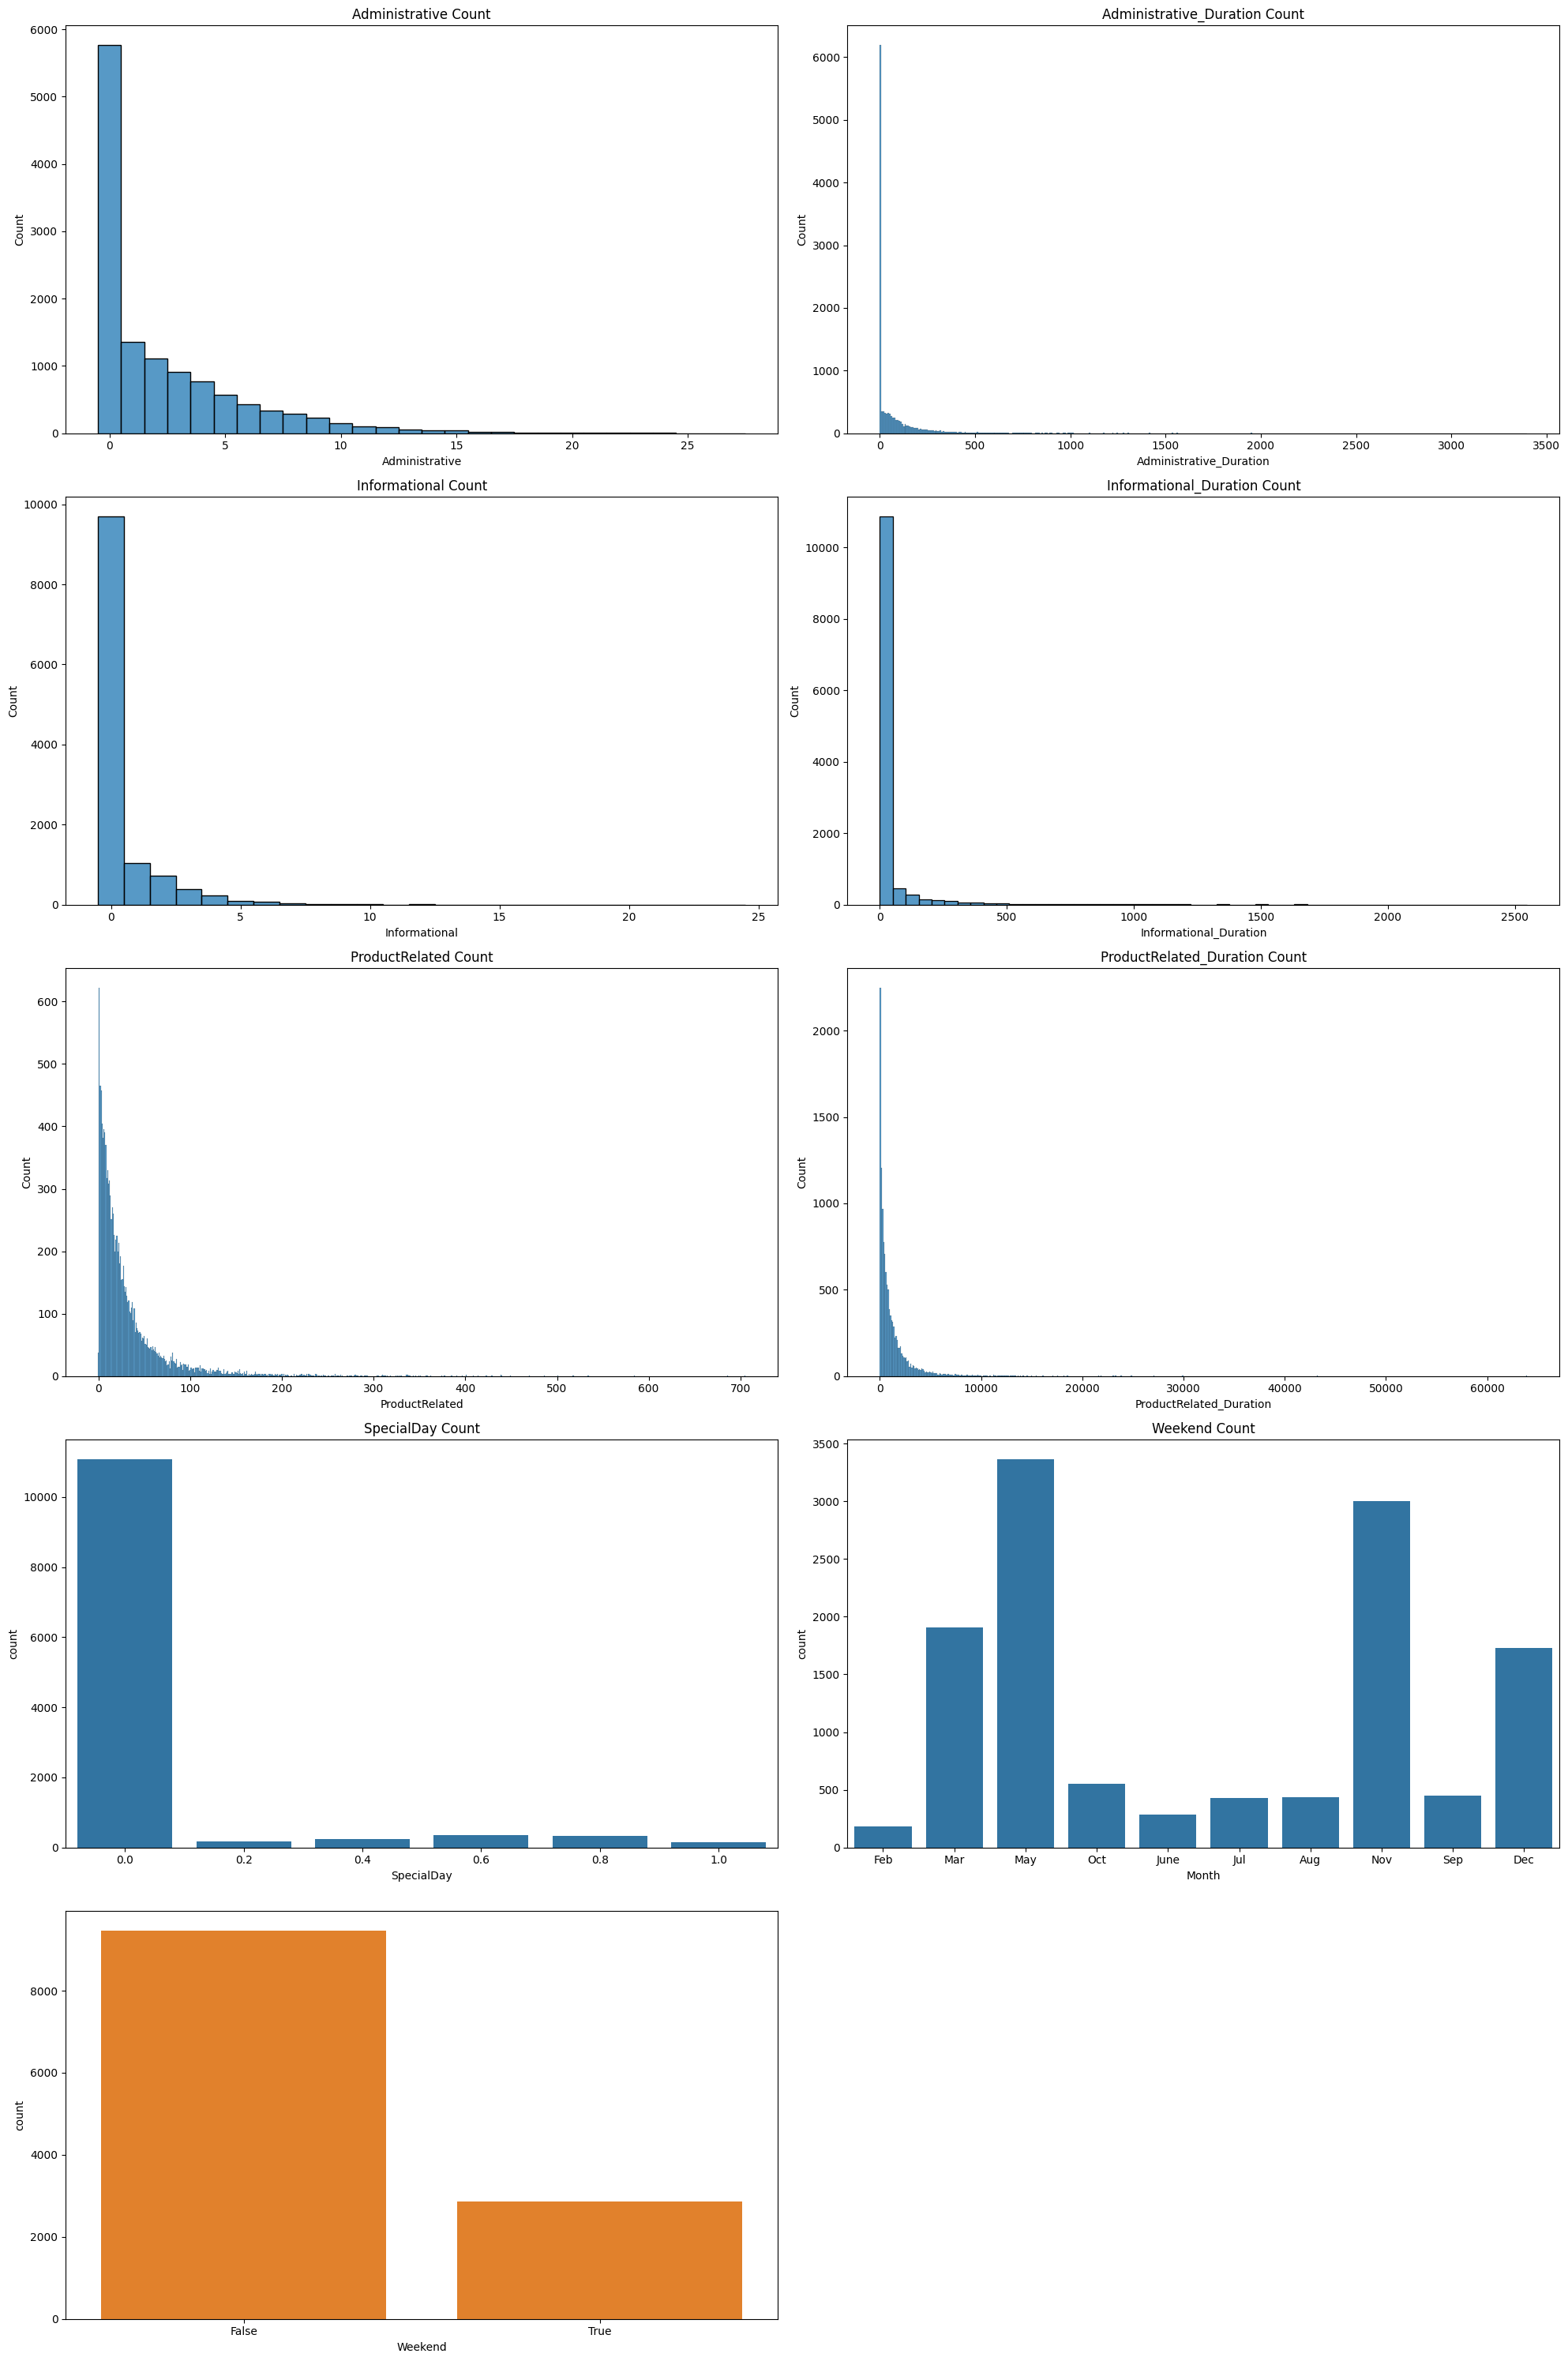

In [7]:
fig, axis = plt.subplots(5, 2, figsize=(20, 30))

sns.histplot(data=df1, x='Administrative', discrete=True, ax=axis[0, 0])
axis[0, 0].set_title('Administrative Count')

sns.histplot(data=df1, x='Administrative_Duration', ax=axis[0, 1])
axis[0, 1].set_title('Administrative_Duration Count')

sns.histplot(data=df1, x='Informational', discrete=True, ax=axis[1, 0])
axis[1, 0].set_title('Informational Count')

sns.histplot(data=df1, x='Informational_Duration', bins=50, ax=axis[1, 1])
axis[1, 1].set_title('Informational_Duration Count')

sns.histplot(data=df1, x='ProductRelated', discrete=True, ax=axis[2, 0])
axis[2, 0].set_title('ProductRelated Count')

sns.histplot(data=df1, x='ProductRelated_Duration', ax=axis[2, 1])
axis[2, 1].set_title('ProductRelated_Duration Count')

sns.countplot(data=df1, x='SpecialDay', ax=axis[3, 0])
axis[3, 0].set_title('SpecialDay Count')

sns.countplot(data=df1, x='Month', ax=axis[3, 1])
axis[3, 1].set_title('Month Count')

sns.countplot(data=df1, x='Weekend', ax=axis[4, 0])
axis[3, 1].set_title('Weekend Count')

sns.countplot(data=df1, x='Weekend', ax=axis[4, 0])
axis[3, 1].set_title('Weekend Count')

fig.delaxes(axis[4, 1])
plt.tight_layout()
plt.savefig('./output/subplots.jpg')
plt.show()

In [8]:
variaveis_qtd  =  ['Administrative', 'Administrative_Duration', 'Informational', 
                   'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']

variaveis_cat = ['SpecialDay', 'Month', 'Weekend']

df_pad = pd.DataFrame(StandardScaler().fit_transform(df1[variaveis_qtd]), columns=df1[variaveis_qtd].columns)
df_pad[variaveis_cat] = df1[variaveis_cat]
print(df_pad.shape)
print(df_pad.info())
df_pad.head()

(12330, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  float64
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  float64
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  float64
 5   ProductRelated_Duration  12330 non-null  float64
 6   SpecialDay               12330 non-null  float64
 7   Month                    12330 non-null  object 
 8   Weekend                  12330 non-null  bool   
dtypes: bool(1), float64(7), object(1)
memory usage: 782.8+ KB
None


Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               -0.244931       -0.691003                -0.624348   
1               -0.244931       -0.668518                -0.590903   
2               -0.244931       -0.691003                -0.624348   
3               -0.244931       -0.668518                -0.622954   
4               -0.244931       -0.488636                -0.296430   

   SpecialDay Month  Weekend  
0         0.0   Feb    False  
1         0.0   Feb    False  
2         0.0   Feb    False  
3         0.0   Feb    False  
4         0.0   Feb     True

In [9]:
pg2 = pd.get_dummies(df_pad[variaveis].dropna(), columns=variaveis_cat, dtype=int)
print(pg2.info())
pg2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  float64
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  float64
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  float64
 5   ProductRelated_Duration  12330 non-null  float64
 6   SpecialDay_0.0           12330 non-null  int32  
 7   SpecialDay_0.2           12330 non-null  int32  
 8   SpecialDay_0.4           12330 non-null  int32  
 9   SpecialDay_0.6           12330 non-null  int32  
 10  SpecialDay_0.8           12330 non-null  int32  
 11  SpecialDay_1.0           12330 non-null  int32  
 12  Month_Aug                12330 non-null  int32  
 13  Month_Dec                12330 non-null  int32  
 14  Month_Feb             

Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0               -0.244931       -0.691003                -0.624348   
1               -0.244931       -0.668518                -0.590903   
2               -0.244931       -0.691003                -0.624348   
3               -0.244931       -0.668518                -0.622954   
4               -0.244931       -0.488636                -0.296430   

   SpecialDay_0.0  SpecialDay_0.2  SpecialDay_0.4  SpecialDay_0.6  ...  \
0               1               0               0               0  ...   
1               1               0               0               0  ...   
2               1               0               0               0  ...   
3               1               0               0               0  ...   
4               1               0               0               0  ...   

   Month_Feb  Month_Jul  Month_June  Month_Mar  Month_May  Month_Nov  \
0          1          0           0          0          0          0   
1          1          0           0          0          0          0   
2          1          0           0          0          0          0   
3          1          0           0          0          0          0   
4          1          0           0          0          0          0   

   Month_Oct  Month_Sep  Weekend_False  Weekend_True  
0          0          0              1             0  
1          0          0              1             0  
2          0          0              1             0  
3          0          0              1             0  
4          0          0              0             1  

[5 rows x 24 columns]

In [10]:
pg2.columns.values

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'SpecialDay_0.0', 'SpecialDay_0.2',
       'SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8',
       'SpecialDay_1.0', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'Weekend_False', 'Weekend_True'],
      dtype=object)

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [11]:
vars_cat = [True if x in {'SpecialDay_0.0', 'SpecialDay_0.2',
       'SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8',
       'SpecialDay_1.0', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'Weekend_False', 'Weekend_True'} else False for x in pg2.columns]
distancia_gower = gower_matrix(pg2, cat_features=vars_cat)
gdv = squareform(distancia_gower,force='tovector')
gdv.shape

(76008285,)

In [12]:
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

id1      id2  dist    n
0   0.0      2.0   0.0  2.0
1  16.0  12330.0   0.0  3.0
2   6.0     79.0   0.0  2.0
3  24.0     50.0   0.0  2.0
4  91.0  12333.0   0.0  3.0

In [13]:
pg2['grupo_3'] = fcluster(Z, 3, criterion='maxclust')
pg2.grupo_3.value_counts()

grupo_3
2    6657
1    2840
3    2833
Name: count, dtype: int64

In [14]:
pg2['grupo_4'] = fcluster(Z, 4, criterion='maxclust')
pg2.grupo_4.value_counts()

grupo_4
2    6657
1    2840
3    2649
4     184
Name: count, dtype: int64

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [15]:
pg3 = df.reset_index().merge(pg2.reset_index(), on='index', how='left')
pg3

index  Administrative_x  Administrative_Duration_x  Informational_x  \
0          0                 0                        0.0                0   
1          1                 0                        0.0                0   
2          2                 0                        0.0                0   
3          3                 0                        0.0                0   
4          4                 0                        0.0                0   
...      ...               ...                        ...              ...   
12325  12325                 3                      145.0                0   
12326  12326                 0                        0.0                0   
12327  12327                 0                        0.0                0   
12328  12328                 4                       75.0                0   
12329  12329                 0                        0.0                0   

       Informational_Duration_x  ProductRelated_x  ProductRelated_Duration_x  \
0                           0.0                 1                   0.000000   
1                           0.0                 2                  64.000000   
2                           0.0                 1                   0.000000   
3                           0.0                 2                   2.666667   
4                           0.0                10                 627.500000   
...                         ...               ...                        ...   
12325                       0.0                53                1783.791667   
12326                       0.0                 5                 465.750000   
12327                       0.0                 6                 184.250000   
12328                       0.0                15                 346.000000   
12329                       0.0                 3                  21.250000   

       BounceRates  ExitRates  PageValues  ...  Month_June Month_Mar  \
0         0.200000   0.200000    0.000000  ...           0         0   
1         0.000000   0.100000    0.000000  ...           0         0   
2         0.200000   0.200000    0.000000  ...           0         0   
3         0.050000   0.140000    0.000000  ...           0         0   
4         0.020000   0.050000    0.000000  ...           0         0   
...            ...        ...         ...  ...         ...       ...   
12325     0.007143   0.029031   12.241717  ...           0         0   
12326     0.000000   0.021333    0.000000  ...           0         0   
12327     0.083333   0.086667    0.000000  ...           0         0   
12328     0.000000   0.021053    0.000000  ...           0         0   
12329     0.000000   0.066667    0.000000  ...           0         0   

       Month_May  Month_Nov  Month_Oct  Month_Sep Weekend_False  Weekend_True  \
0              0          0          0          0             1             0   
1              0          0          0          0             1             0   
2              0          0          0          0             1             0   
3              0          0          0          0             1             0   
4              0          0          0          0             0             1   
...          ...        ...        ...        ...           ...           ...   
12325          0          0          0          0             0             1   
12326          0          1          0          0             0             1   
12327          0          1          0          0             0             1   
12328          0          1          0          0             1             0   
12329          0          1          0          0             0             1   

       grupo_3  grupo_4  
0            3        4  
1            3        4  
2            3        4  
3            3        4  
4            3        4  
...        ...      ...  
12325        1        1  
12326        1        1  
12327        1        1  
12328      

**3 Grupos:**

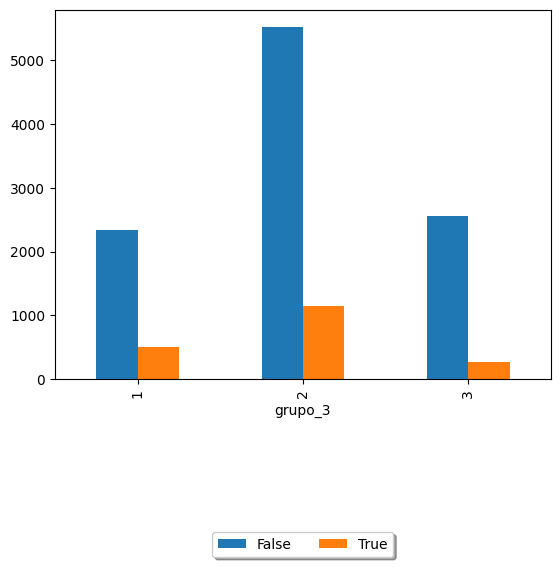

In [16]:
ax = pg3.groupby(['grupo_3', 'Revenue'])['Revenue'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

In [17]:
pd.crosstab(pg3['Revenue'], pg3['grupo_3'])

grupo_3     1     2     3
Revenue                  
False    2342  5516  2564
True      498  1141   269

In [18]:
pd.crosstab(pg3['Revenue'], pg3['grupo_3'], normalize='columns')

grupo_3         1         2         3
Revenue                              
False    0.824648  0.828601  0.905048
True     0.175352  0.171399  0.094952

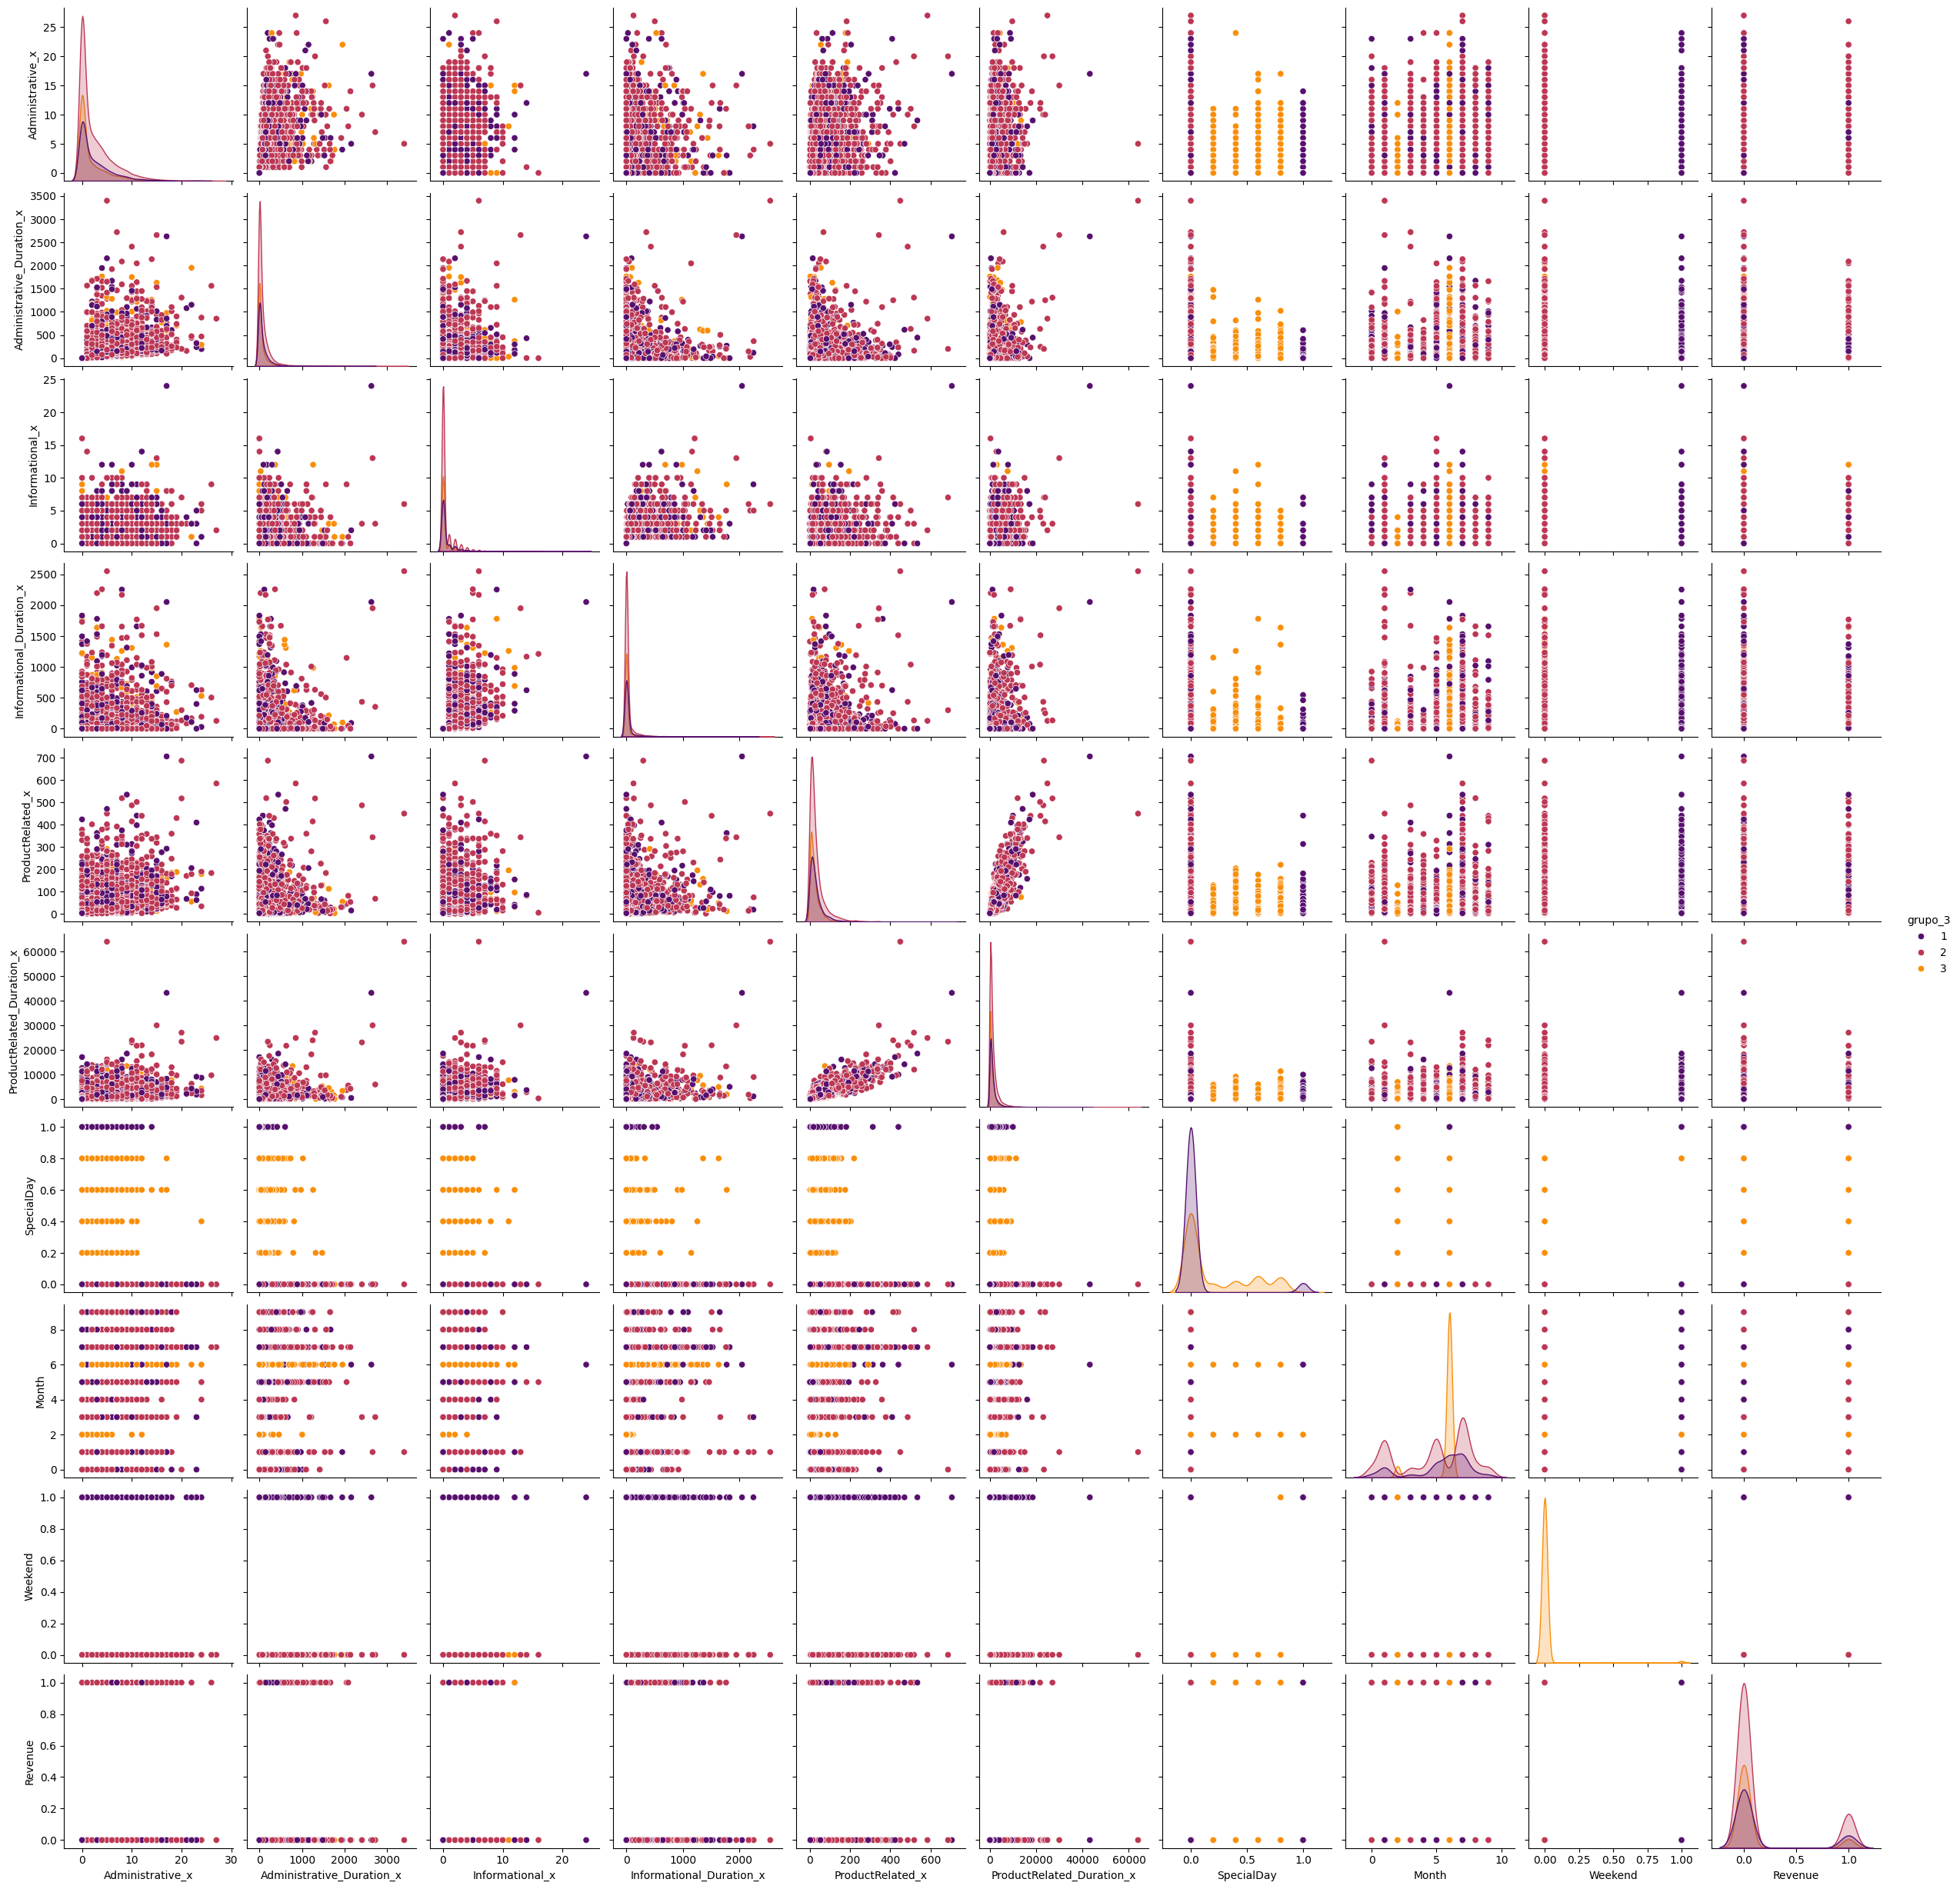

In [19]:
variaveis = ['Administrative_x', 'Administrative_Duration_x', 'Informational_x',
    'Informational_Duration_x', 'ProductRelated_x', 'ProductRelated_Duration_x',
    'SpecialDay', 'Month', 'Weekend', 'Revenue', 'grupo_3']

pg3['Month'] = pg3['Month'].astype('category').cat.codes
pg3['Weekend'] = pg3['Weekend'].astype(int)
pg3['Revenue'] = pg3['Revenue'].astype(int)

palette = sns.color_palette("inferno", 3)
sns.pairplot(data=pg3[variaveis], hue='grupo_3', palette=palette)
plt.savefig('./output/pairplot_grupo_3.jpg')
plt.show()

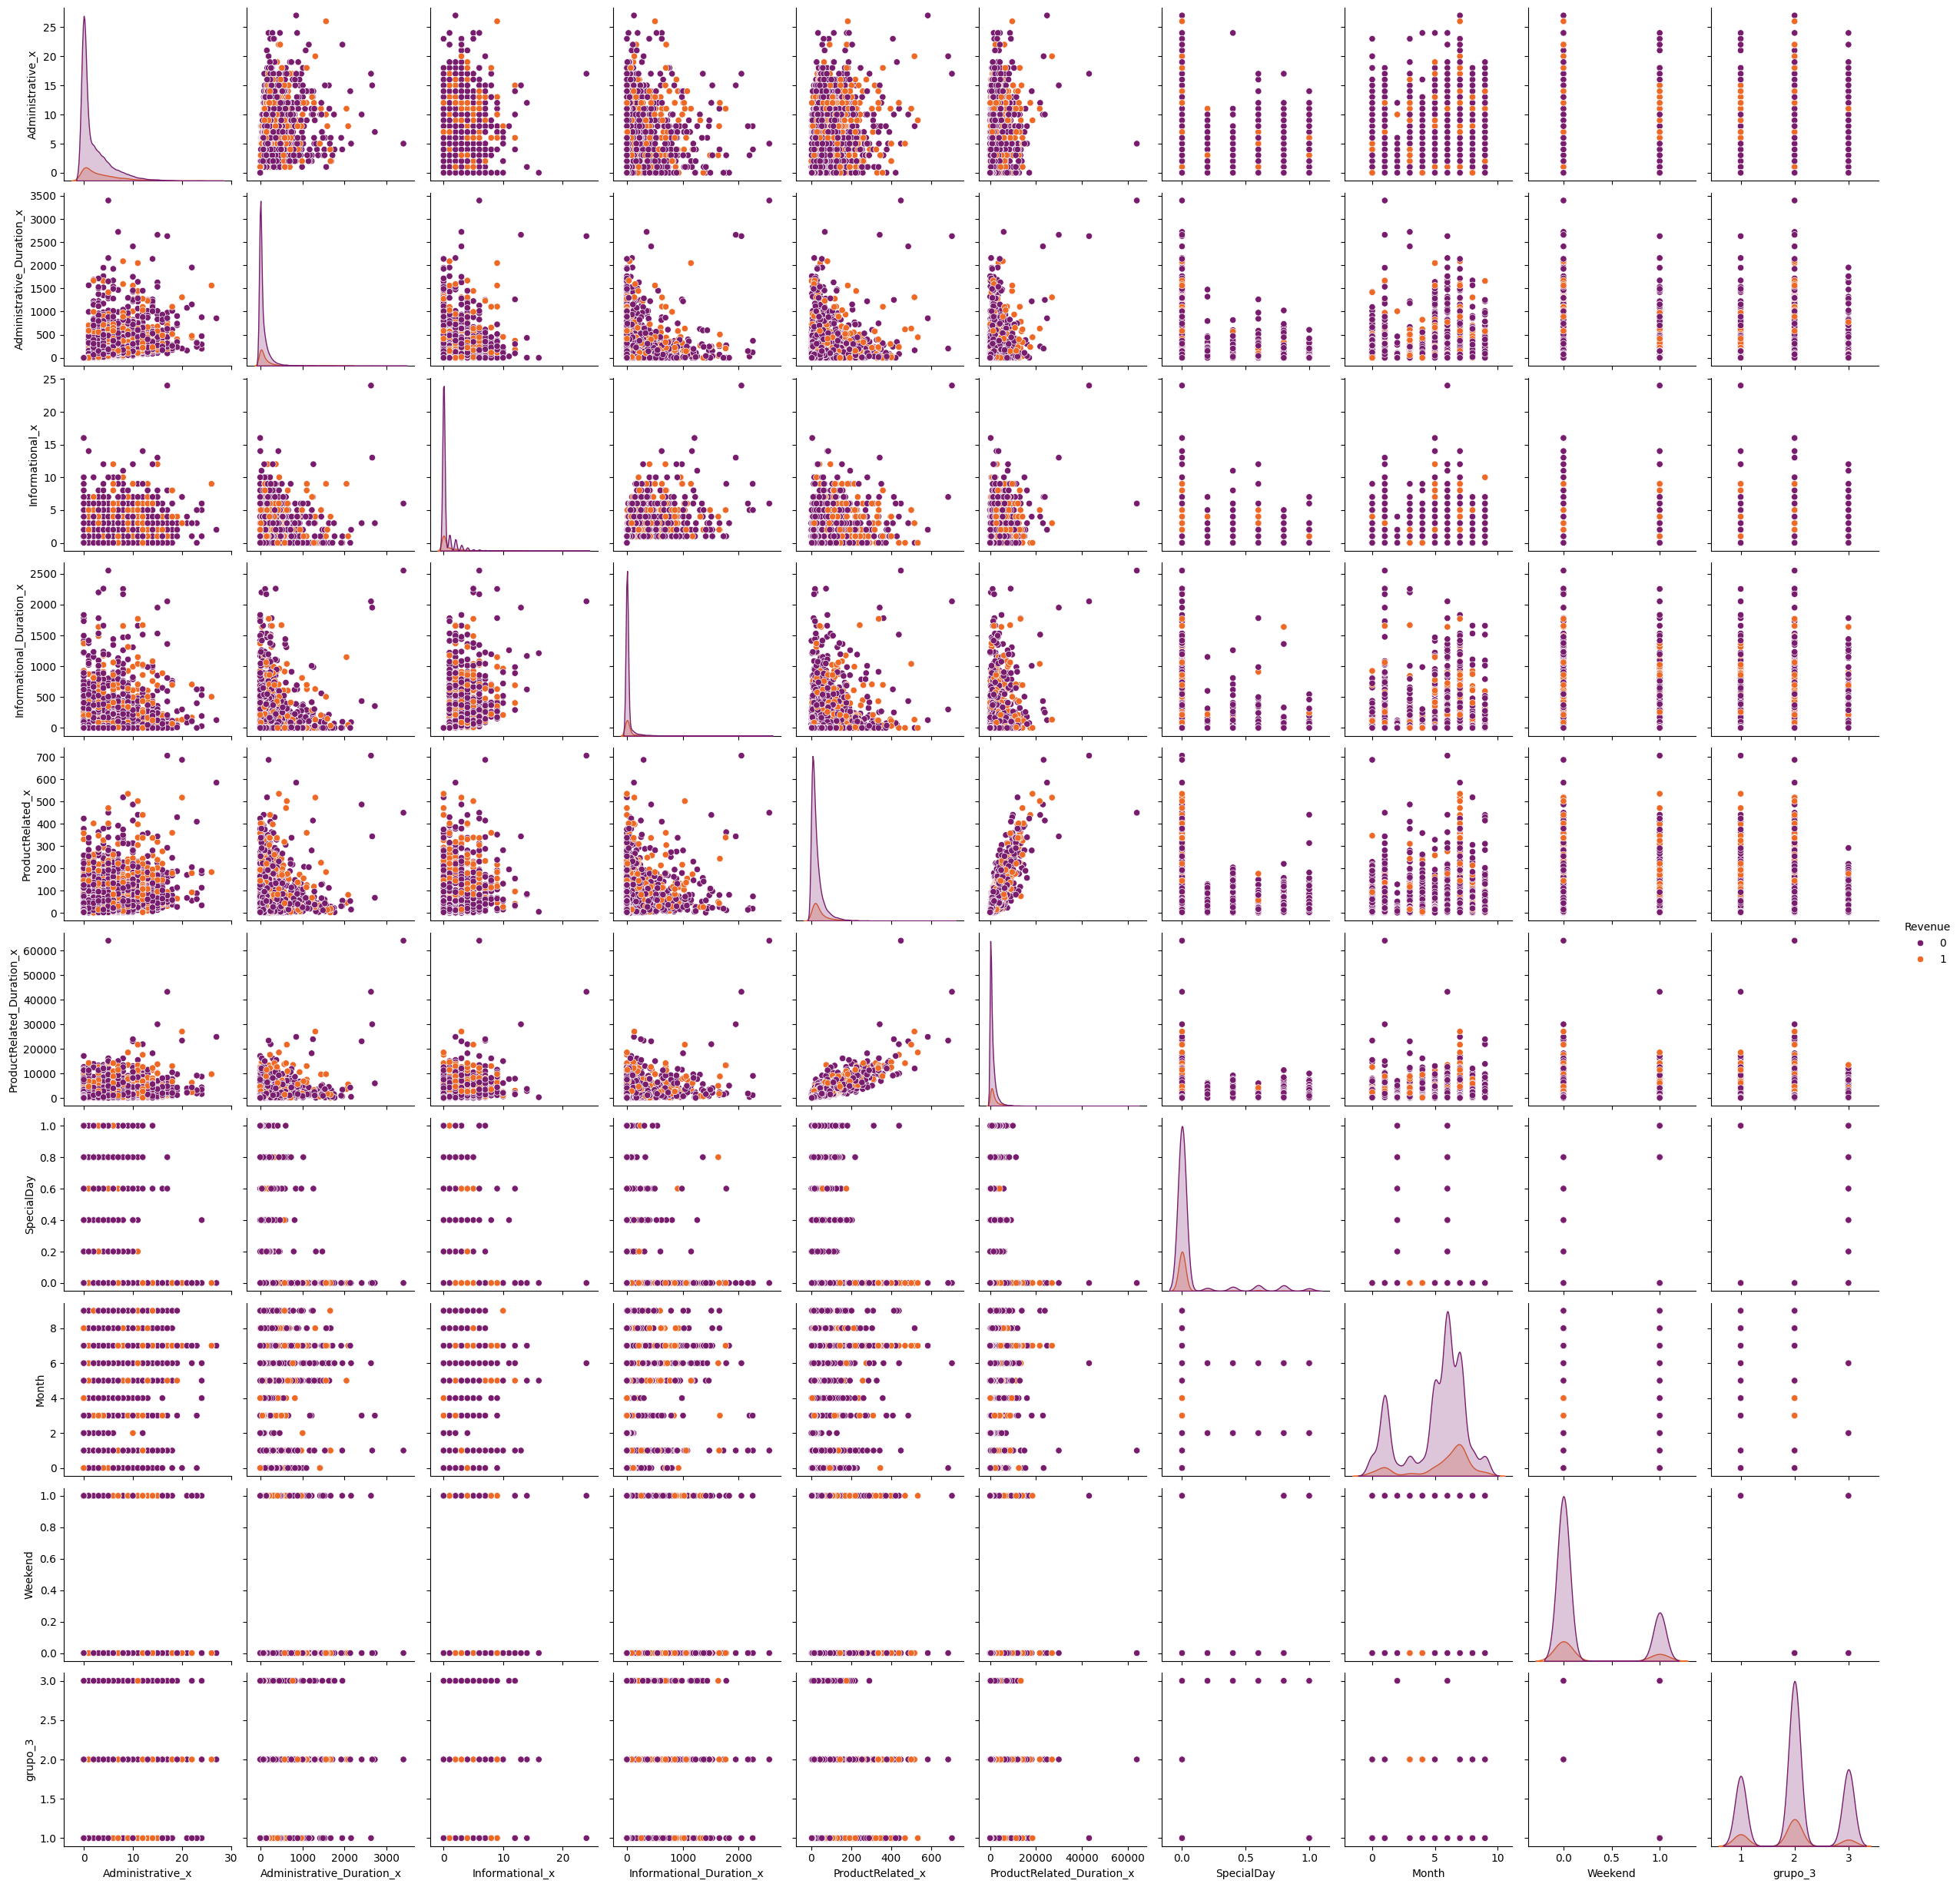

In [20]:
variaveis = ['Administrative_x', 'Administrative_Duration_x', 'Informational_x',
    'Informational_Duration_x', 'ProductRelated_x', 'ProductRelated_Duration_x',
    'SpecialDay', 'Month', 'Weekend', 'Revenue', 'grupo_3']

pg3['Month'] = pg3['Month'].astype('category').cat.codes
pg3['Weekend'] = pg3['Weekend'].astype(int)
pg3['Revenue'] = pg3['Revenue'].astype(int)

palette = sns.color_palette("inferno", 2)
sns.pairplot(data=pg3[variaveis], hue='Revenue', palette=palette)
plt.savefig('./output/pairplot_grupo_3_revenue.jpg')
plt.show()

**4 Grupos**

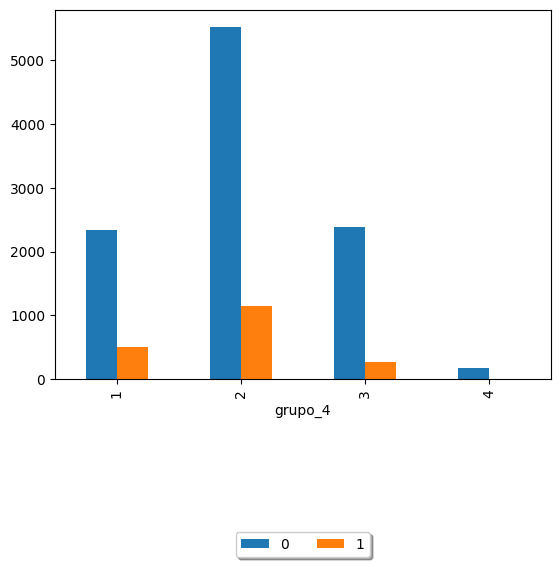

In [21]:
ax = pg3.groupby(['grupo_4', 'Revenue'])['Revenue'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

In [22]:
pd.crosstab(pg3['Revenue'], pg3['grupo_4'])

grupo_4     1     2     3    4
Revenue                       
0        2342  5516  2383  181
1         498  1141   266    3

In [23]:
pd.crosstab(pg3['Revenue'], pg3['grupo_4'], normalize='columns')

grupo_4         1         2         3         4
Revenue                                        
0        0.824648  0.828601  0.899585  0.983696
1        0.175352  0.171399  0.100415  0.016304

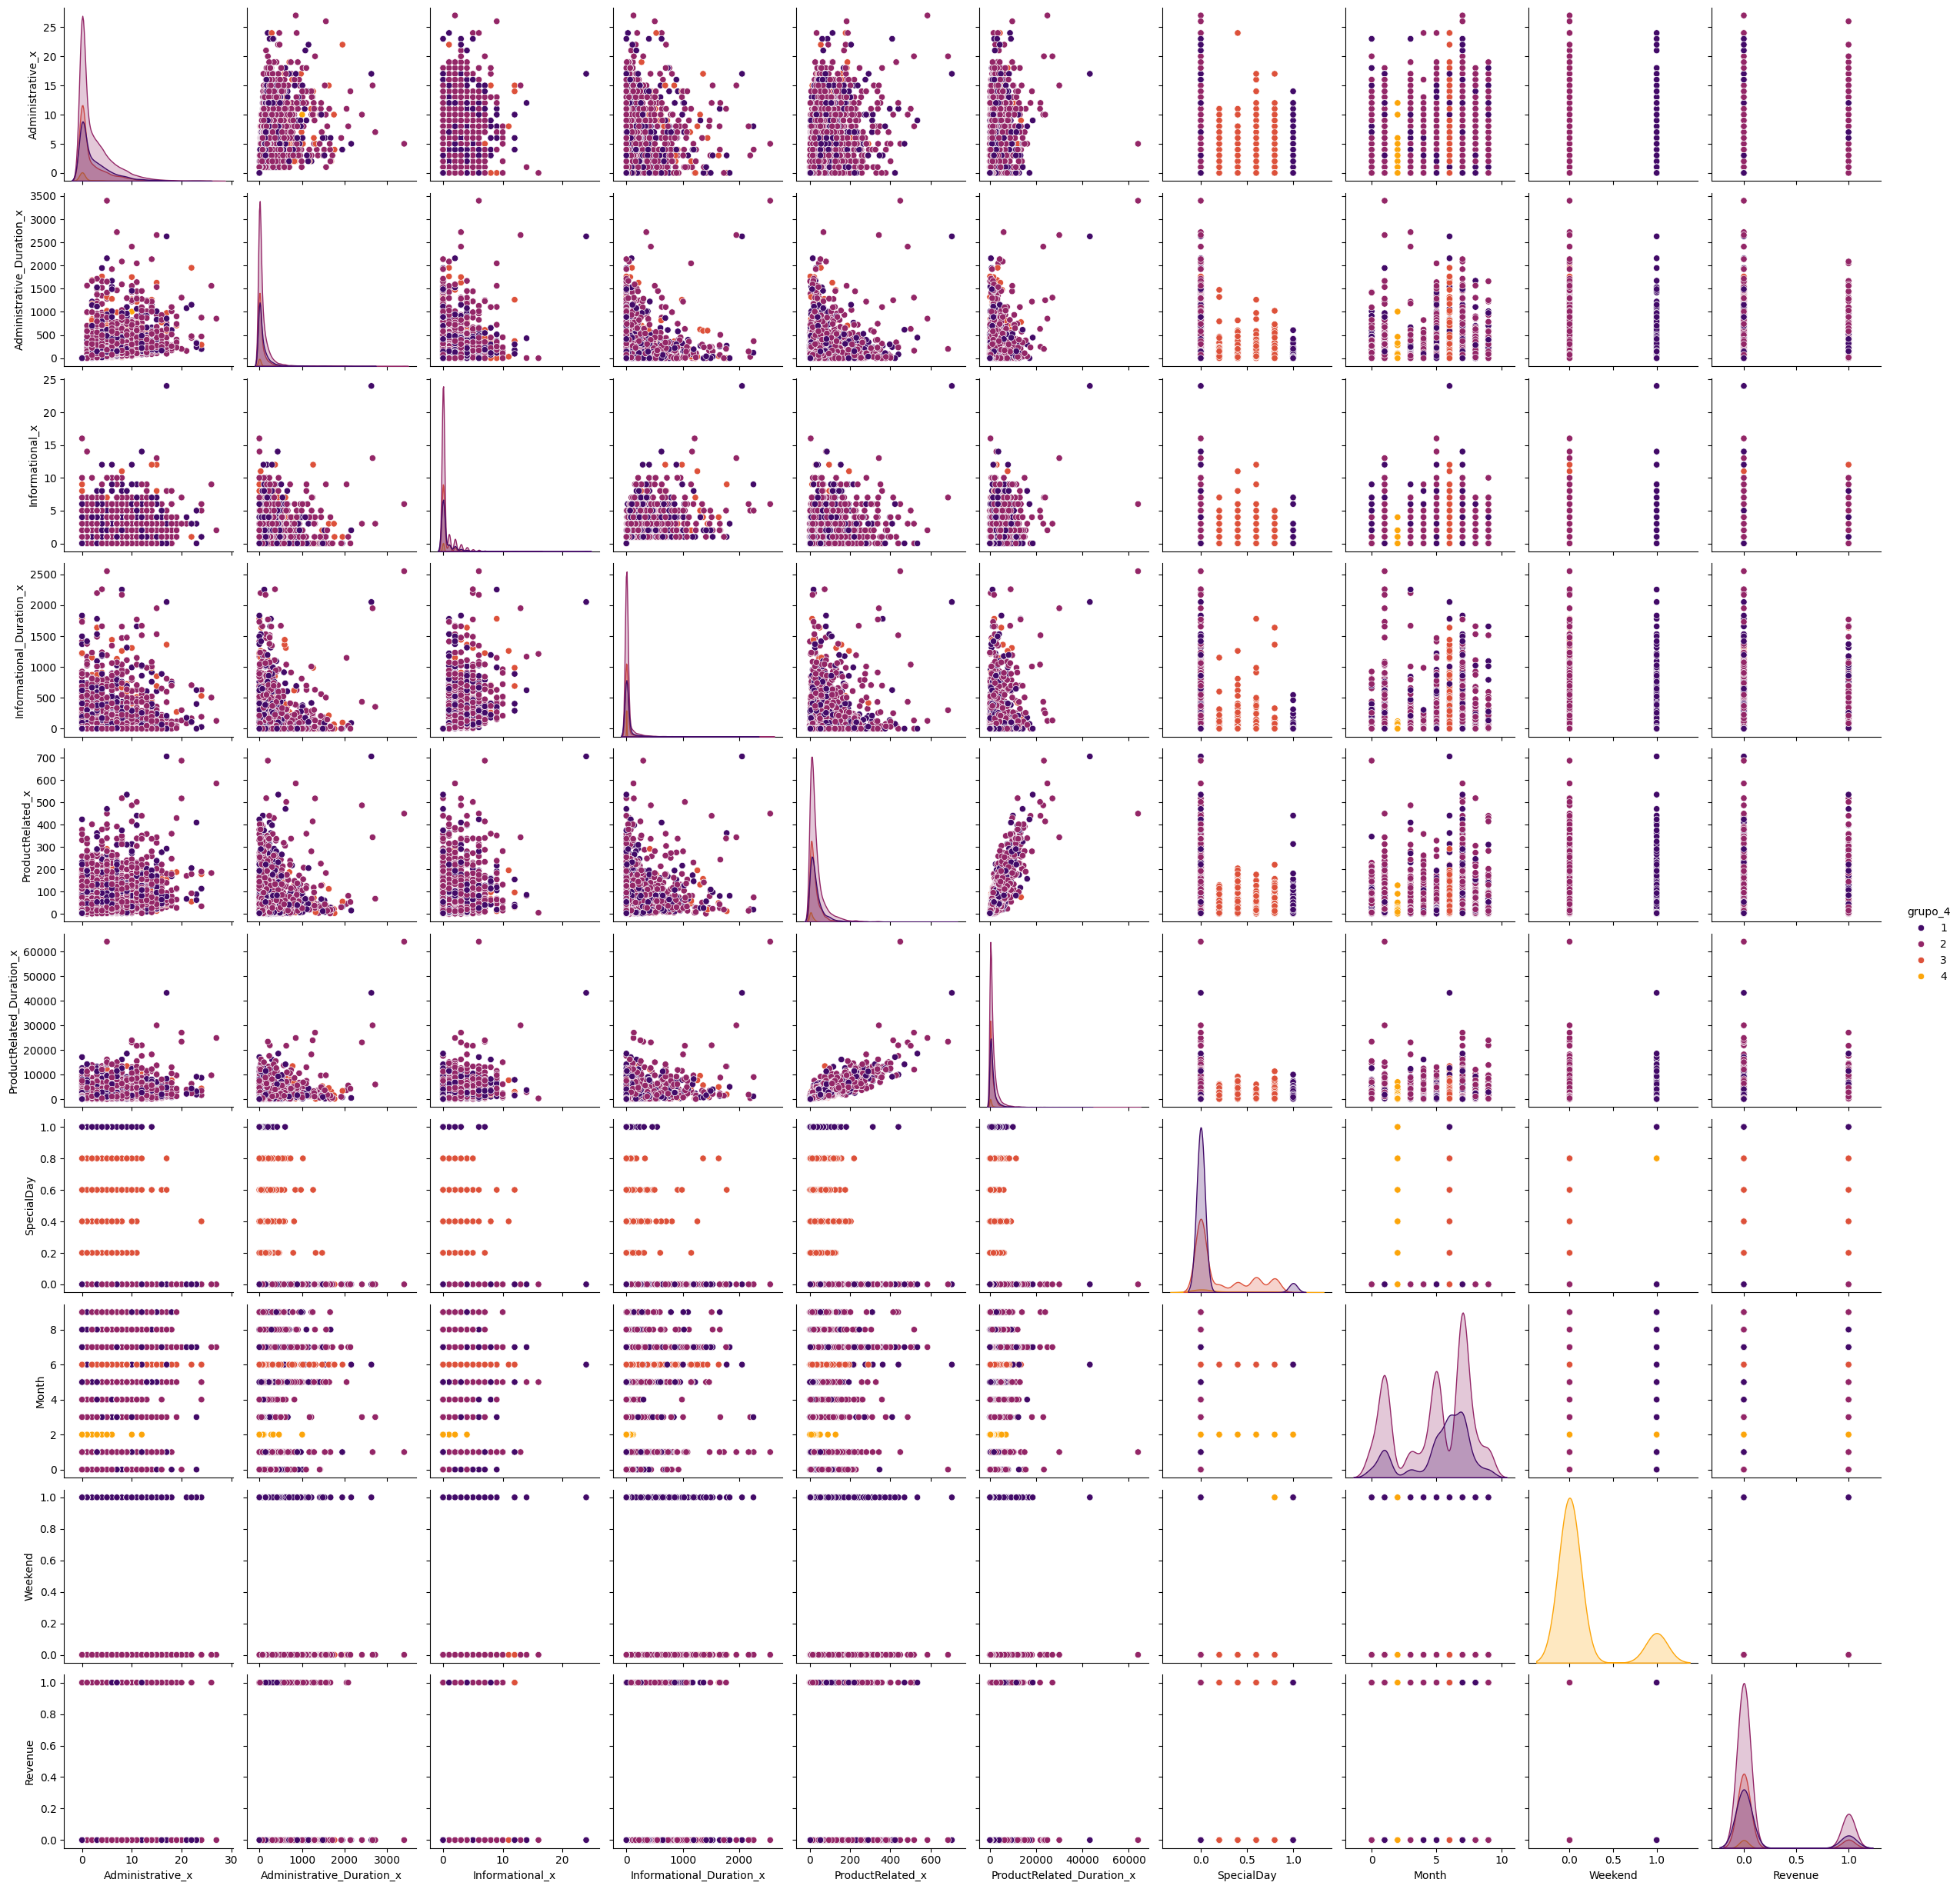

In [24]:
variaveis = ['Administrative_x', 'Administrative_Duration_x', 'Informational_x',
    'Informational_Duration_x', 'ProductRelated_x', 'ProductRelated_Duration_x',
    'SpecialDay', 'Month', 'Weekend', 'Revenue', 'grupo_4']

pg3['Month'] = pg3['Month'].astype('category').cat.codes
pg3['Weekend'] = pg3['Weekend'].astype(int)
pg3['Revenue'] = pg3['Revenue'].astype(int)

palette = sns.color_palette("inferno", 4)
sns.pairplot(data=pg3[variaveis], hue='grupo_4', palette=palette)
plt.savefig('./output/pairplot_grupo_4.jpg')
plt.show()

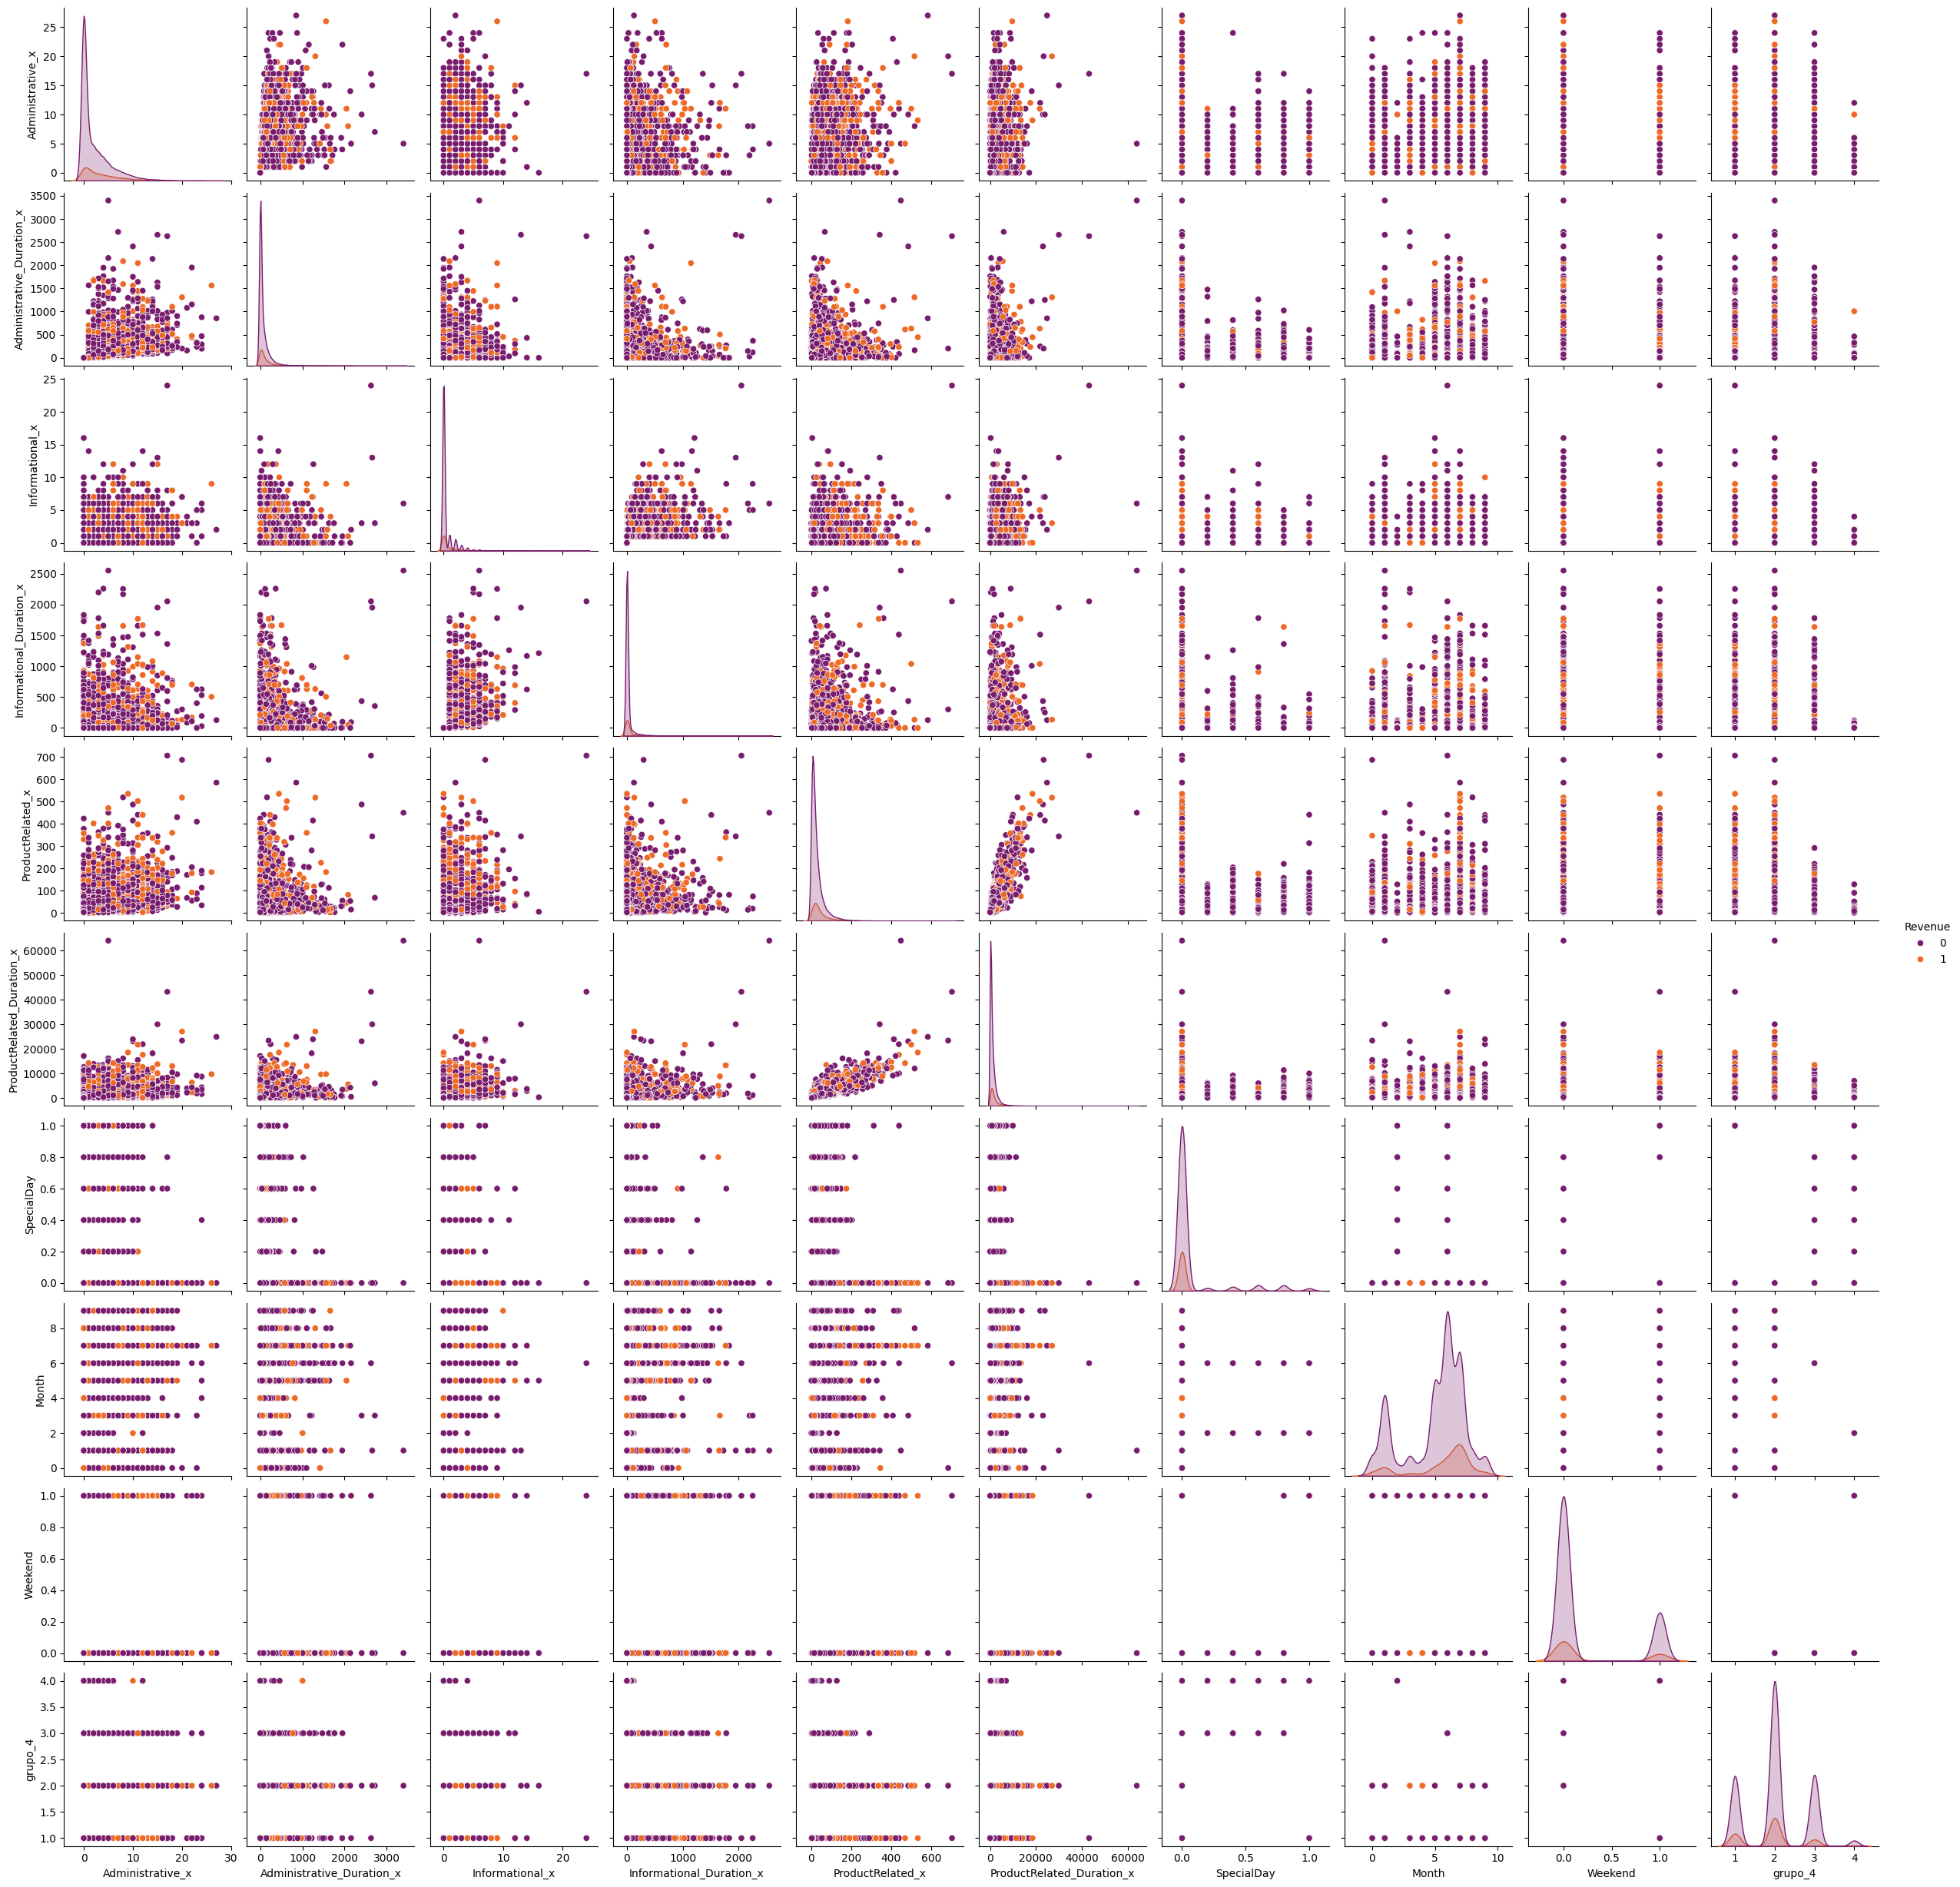

In [25]:
variaveis = ['Administrative_x', 'Administrative_Duration_x', 'Informational_x',
    'Informational_Duration_x', 'ProductRelated_x', 'ProductRelated_Duration_x',
    'SpecialDay', 'Month', 'Weekend', 'Revenue', 'grupo_4']

pg3['Month'] = pg3['Month'].astype('category').cat.codes
pg3['Weekend'] = pg3['Weekend'].astype(int)
pg3['Revenue'] = pg3['Revenue'].astype(int)

palette = sns.color_palette("inferno", 2)
sns.pairplot(data=pg3[variaveis], hue='Revenue', palette=palette)
plt.savefig('./output/pairplot_grupo_4_revenue.jpg')
plt.show()

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

Irei utilizar como parâmetro a divisão em 3 clusters, visto que o grupo adicional com 4 clusters tem menos de 1% de relevância na análise.

In [26]:
bounce_rate_mean = pg3.groupby('grupo_3')['BounceRates'].mean().reset_index()
bounce_rate_mean

grupo_3  BounceRates
0        1     0.017663
1        2     0.020848
2        3     0.029887

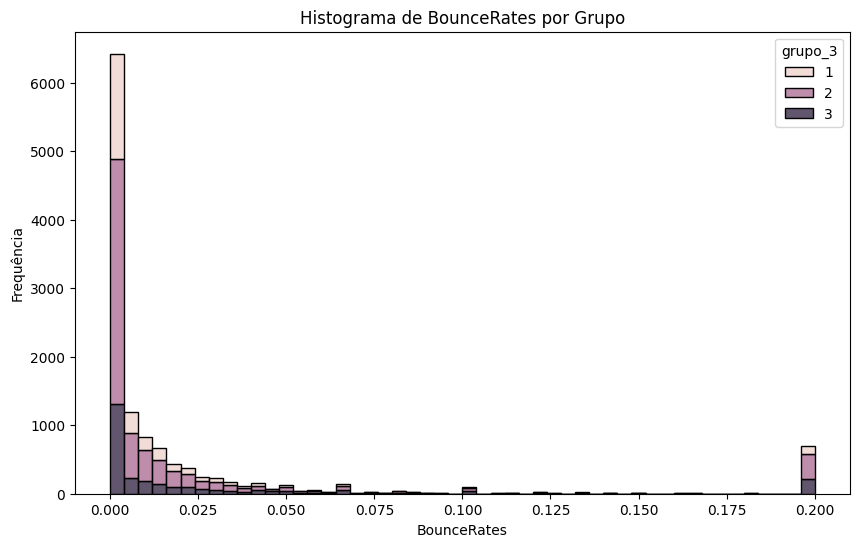

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=pg3, x='BounceRates', hue='grupo_3', multiple='stack', bins=50)
plt.title('Histograma de BounceRates por Grupo')
plt.xlabel('BounceRates')
plt.ylabel('Frequência')
plt.savefig('./output/hist_bounce_rate_grupo_3.jpg')
plt.show()

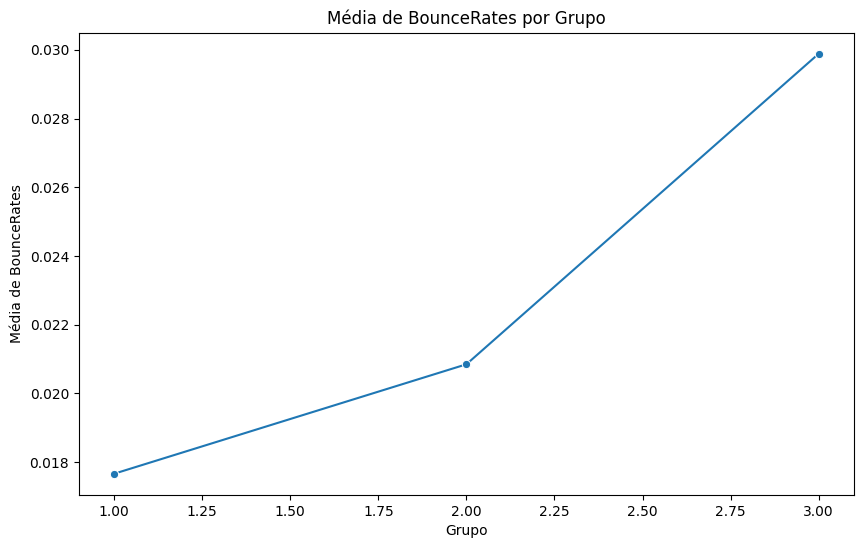

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='grupo_3', y='BounceRates', data=bounce_rate_mean, marker='o')
plt.title('Média de BounceRates por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Média de BounceRates')
plt.savefig('./output/line_bounce_rate_grupo_3.jpg')
plt.show()

In [29]:
pd.crosstab(pg3['Revenue'], pg3['grupo_3'])

grupo_3     1     2     3
Revenue                  
0        2342  5516  2564
1         498  1141   269

In [30]:
pd.crosstab(pg3['Revenue'], pg3['grupo_3'], normalize='columns')

grupo_3         1         2         3
Revenue                              
0        0.824648  0.828601  0.905048
1        0.175352  0.171399  0.094952

### Insight:

O grupo 1 é o mais propício a fechar uma compra, tanto pela melhor proporção de ``Revenue`` quanto pela ``BounceRates``, com páginas que retêm bem os visitantes.